In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from scipy.optimize import curve_fit
import seaborn as sns
from other import data_preprocessing
import xgboost

In [40]:
train = pd.read_parquet('data/train.parquet')

In [41]:
train['None_count'] = train['values'].apply(data_preprocessing.none_count)
train['Len'] = train['values'].apply(len)
train_emp = train.loc[train['None_count'] > 0]
train = train.loc[train['None_count'] == 0].drop(['None_count'], axis=1)
len(train_emp), (train_emp['None_count'] / train_emp['Len']).min()

(88, 1.0)

None присутствует только в 88 строках датасета, если есть None в списке, то весь список состоит из None

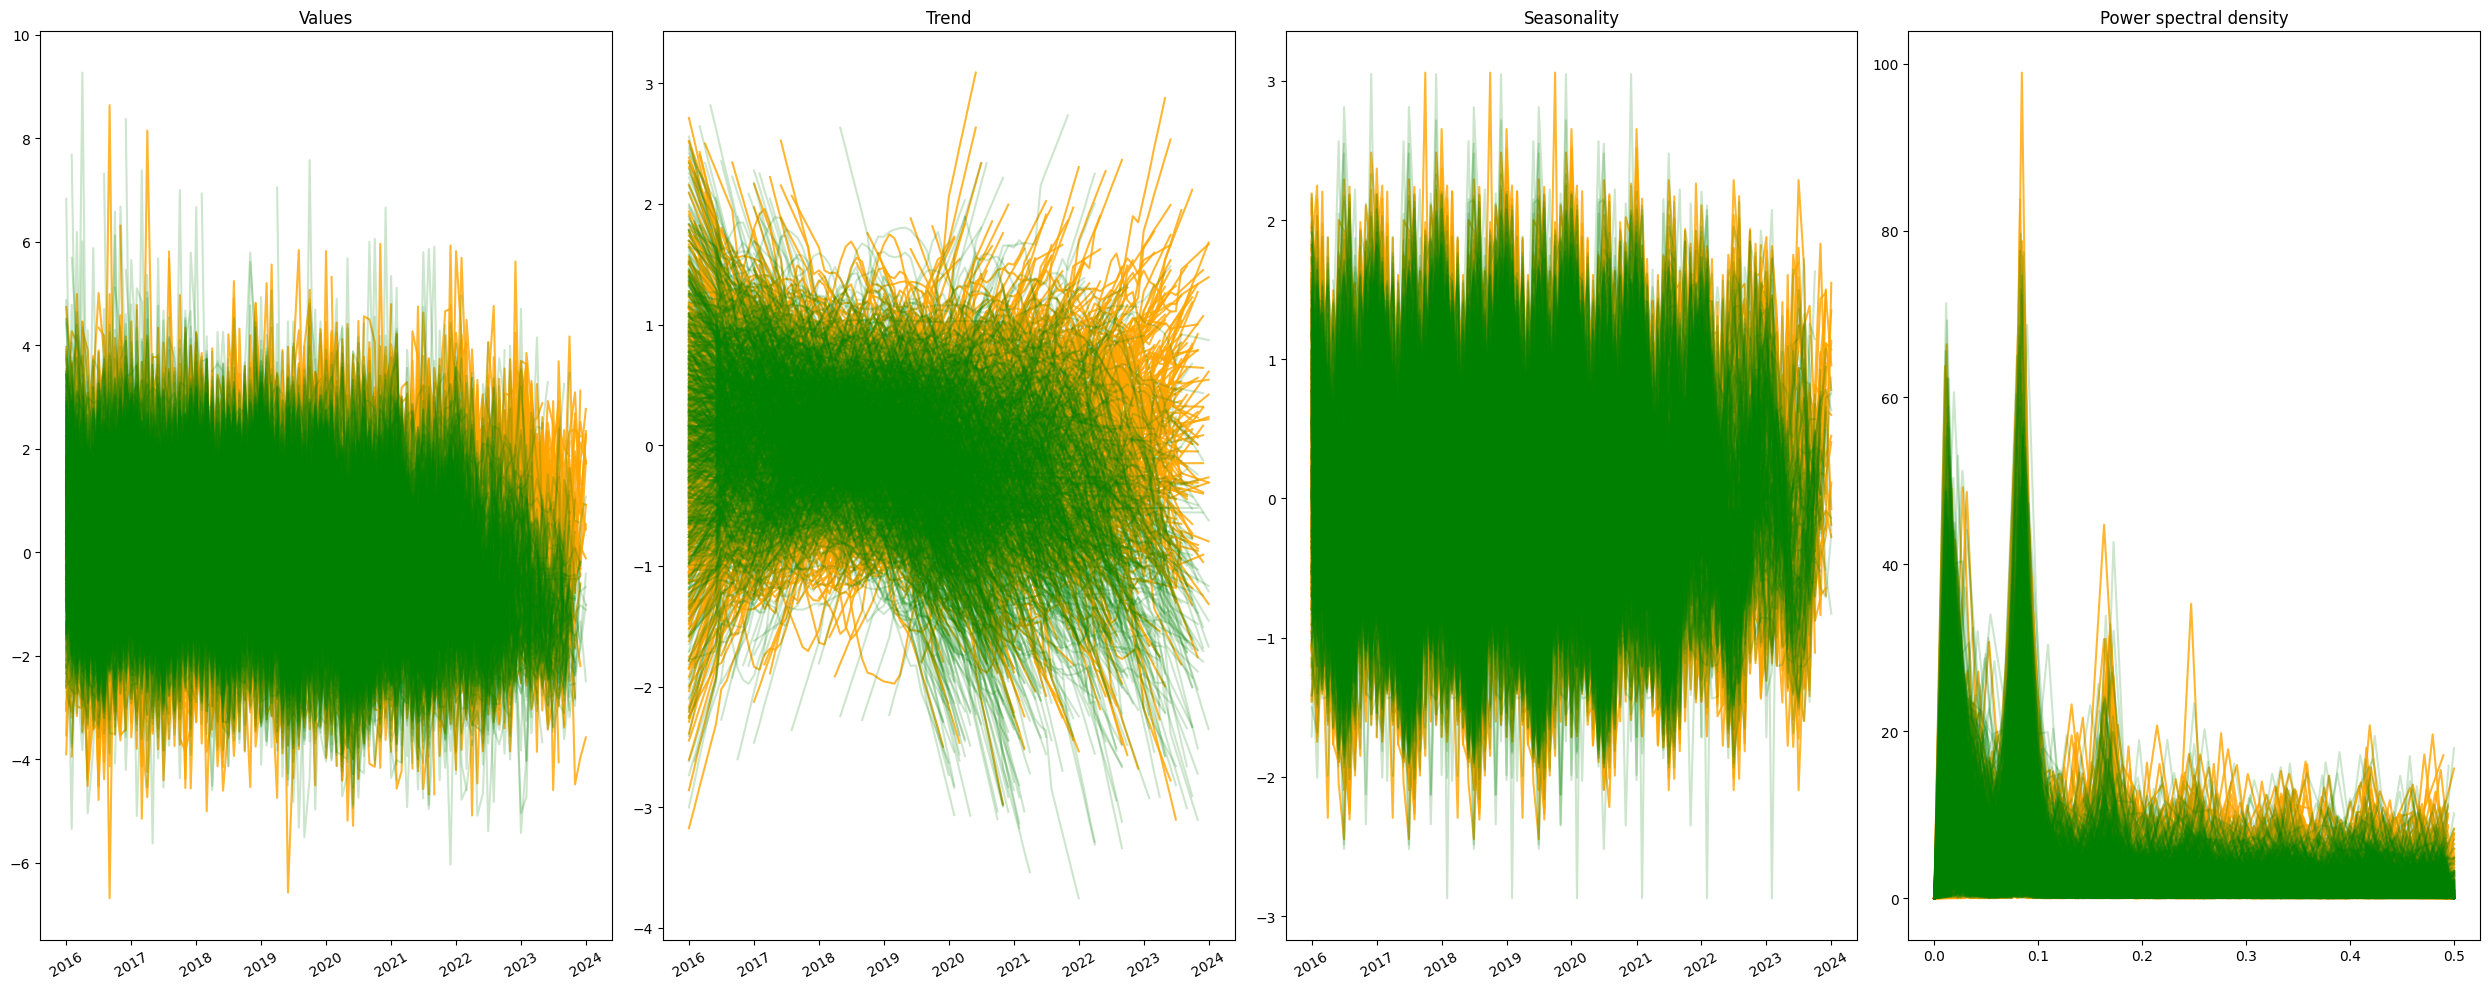

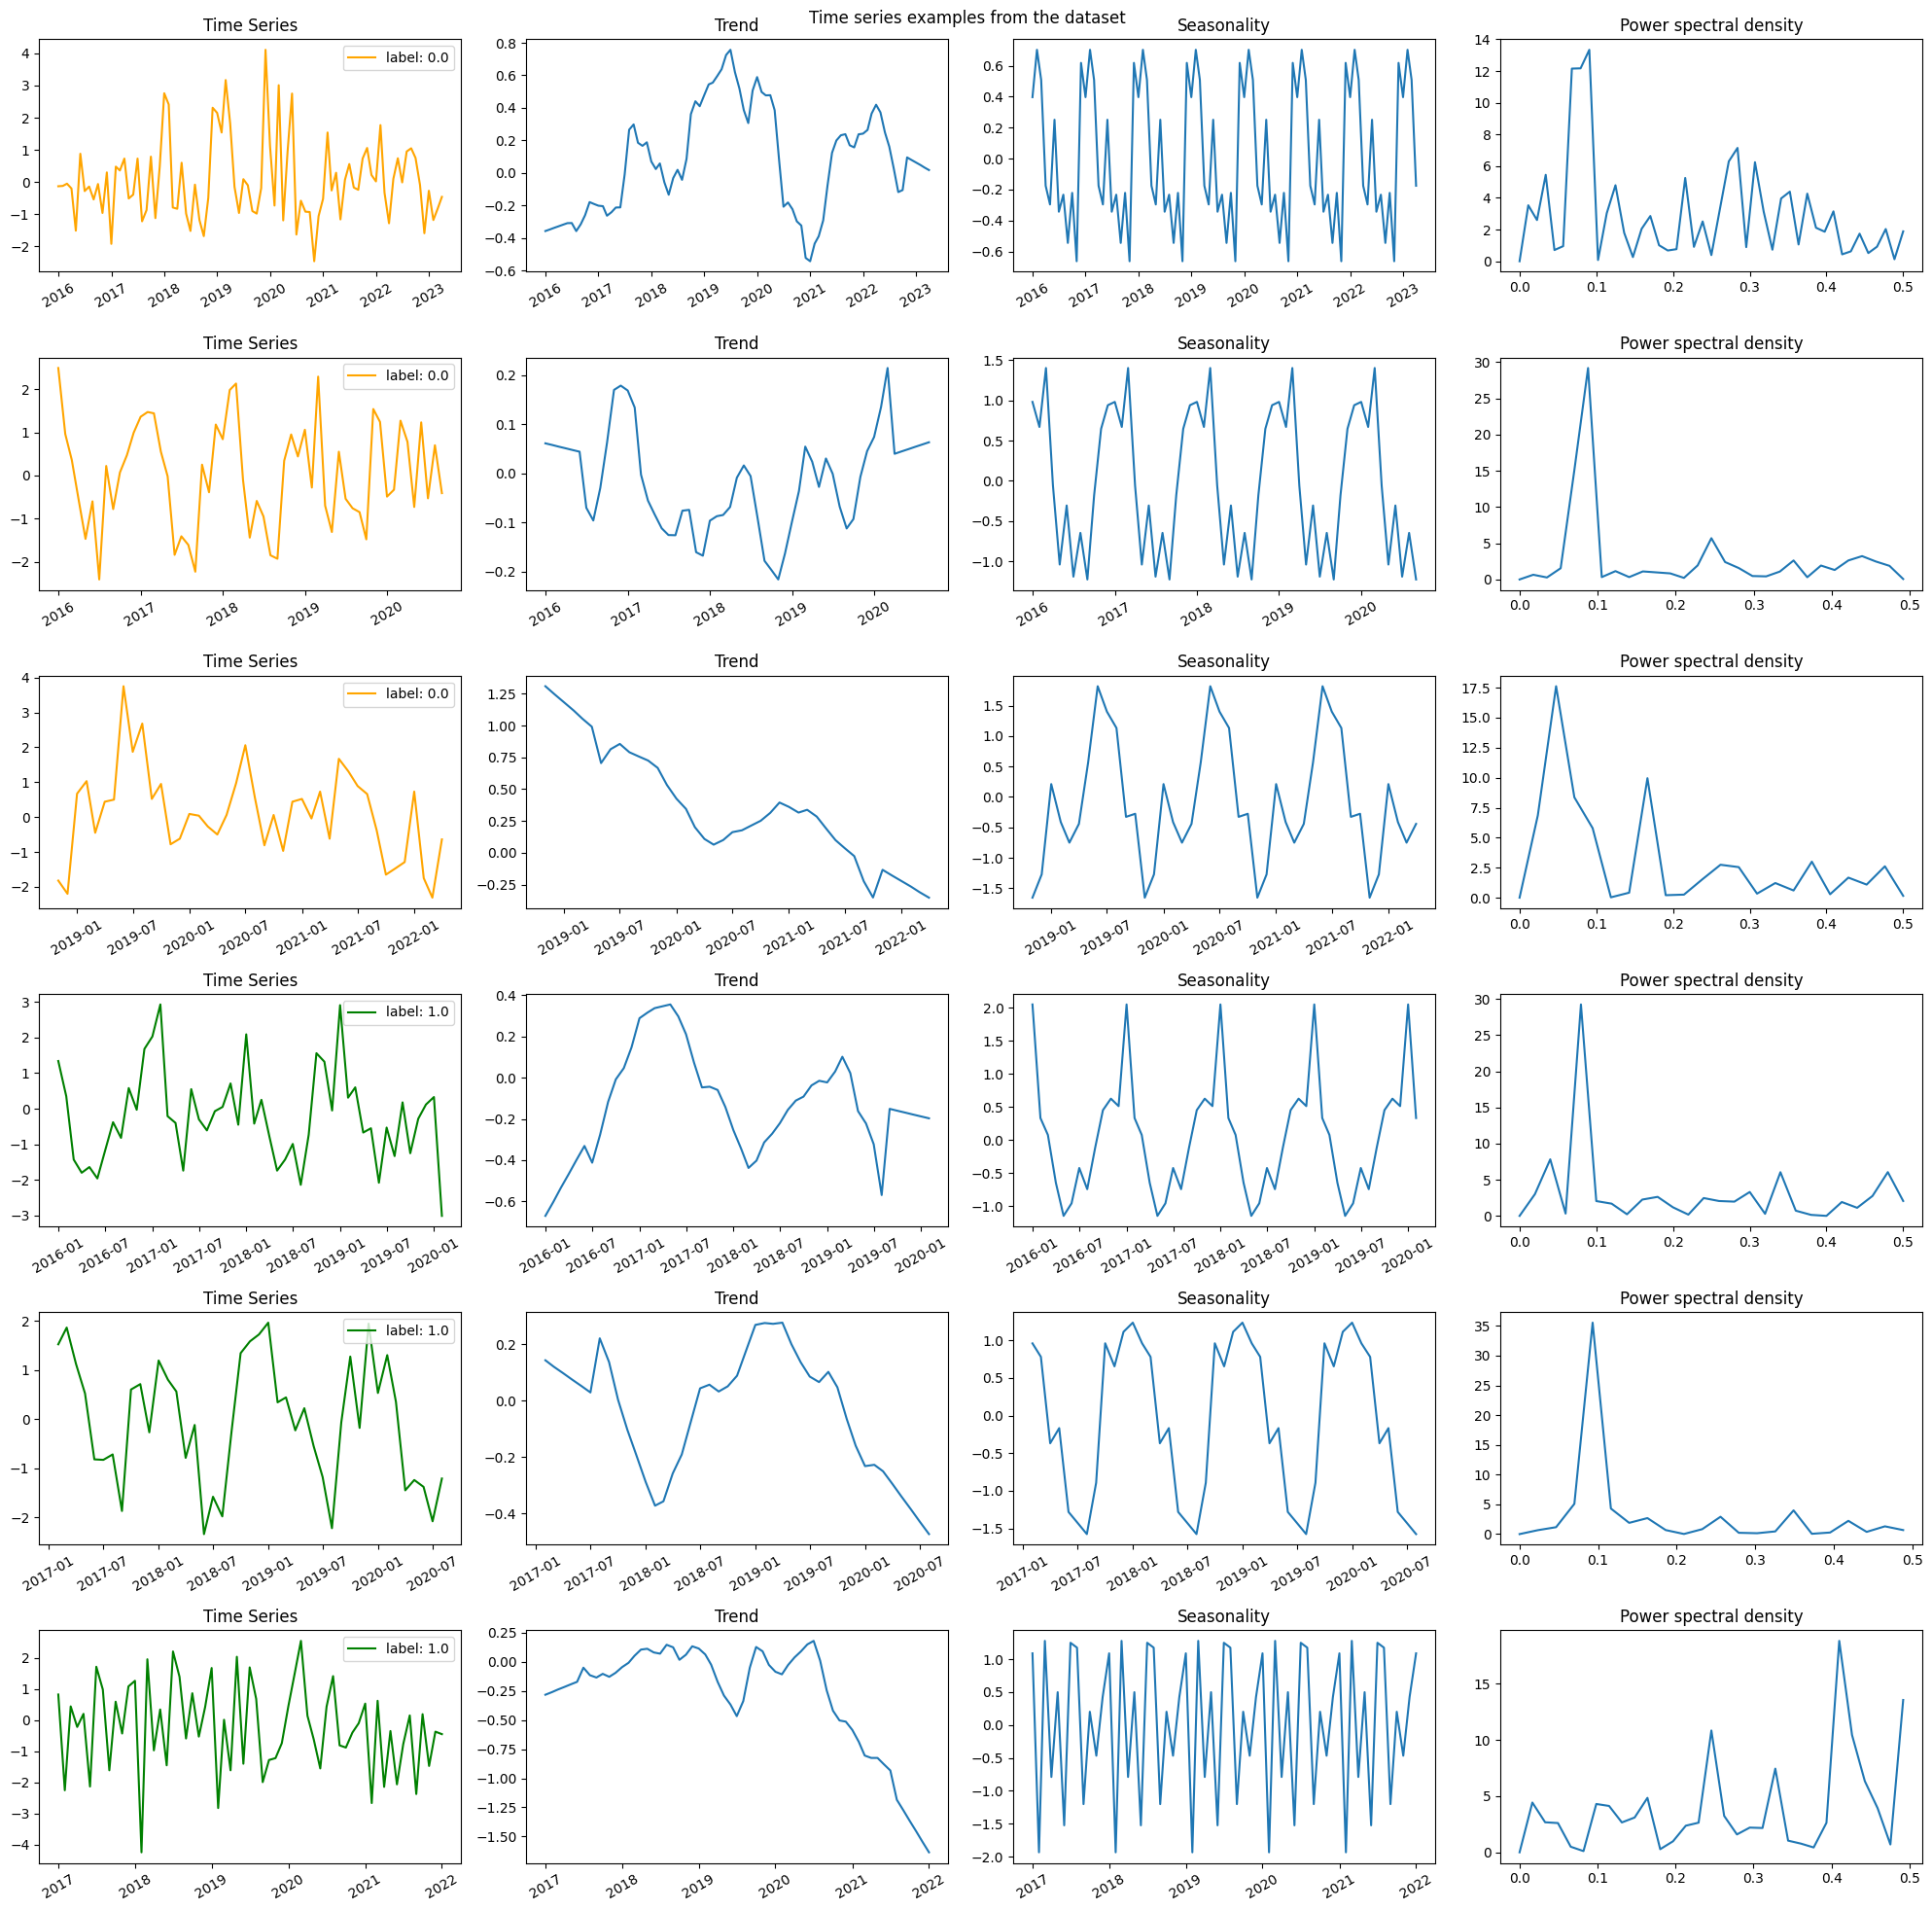

In [5]:
data_preprocessing.show_n_samples(train, 1000)
data_preprocessing.show_ts_samples(train)

In [42]:
train = data_preprocessing.create_new_features(train)

79912it [01:32, 867.06it/s]


In [43]:
X_train, X_test, y_train, y_test = train_test_split(train[['Sum','D','Trend','A','Bias','Mean','Static_count','Var','Outflow','Max','Len','Inflow']], train['label'], test_size=0.2)

In [44]:
from sklearn.model_selection import cross_validate
scores = cross_validate(
    XGBClassifier(learning_rate=0.3, n_estimators=100, eval_metric='auc'), 
    train[['Sum','D','Trend','A','Bias','Mean','Static_count','Var','Outflow','Max','Len','Inflow']], 
    train['label'],
    cv=10, 
    scoring=['roc_auc', 'precision', 'recall'])
scores, scores['test_roc_auc'].mean()

({'fit_time': array([0.31821275, 0.3069315 , 0.33070612, 0.37570739, 0.31139445,
         0.3309989 , 0.31400156, 0.34299827, 0.35800219, 0.35530257]),
  'score_time': array([0.0365696 , 0.03701854, 0.03934717, 0.04443717, 0.03600001,
         0.03399992, 0.03899884, 0.04000115, 0.03999734, 0.04011941]),
  'test_roc_auc': array([0.91918548, 0.91205173, 0.91056151, 0.91153857, 0.9085672 ,
         0.9105118 , 0.9107594 , 0.90725655, 0.90979399, 0.91535257]),
  'test_precision': array([0.8120662 , 0.77835318, 0.78195876, 0.78400831, 0.77961718,
         0.78936392, 0.79205852, 0.76796715, 0.79289941, 0.7983149 ]),
  'test_recall': array([0.6873023 , 0.67916855, 0.6858047 , 0.68264014, 0.68128391,
         0.68413918, 0.68504293, 0.67600542, 0.66606417, 0.68504293])},
 0.9115578797772462)

In [45]:
xgb = XGBClassifier(learning_rate=0.3, n_estimators=100, eval_metric='auc').fit(X_train, y_train)
y_pred = xgb.predict((X_test))
print(y_pred)
roc_auc_score(y_test, xgb.predict_proba((X_test))[:,1]), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

[1 1 0 ... 0 0 0]


(0.9065349453781919, 0.7777490297542043, 0.668)

In [46]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-auc:0.84982
[100]	test-auc:0.87906
[200]	test-auc:0.88691
[300]	test-auc:0.89410
[400]	test-auc:0.90011
[500]	test-auc:0.90410
[600]	test-auc:0.90656
[700]	test-auc:0.90829
[800]	test-auc:0.90953
[900]	test-auc:0.91042
[1000]	test-auc:0.91105
[1100]	test-auc:0.91156
[1200]	test-auc:0.91196
[1300]	test-auc:0.91236
[1400]	test-auc:0.91258
[1500]	test-auc:0.91271
[1509]	test-auc:0.91272


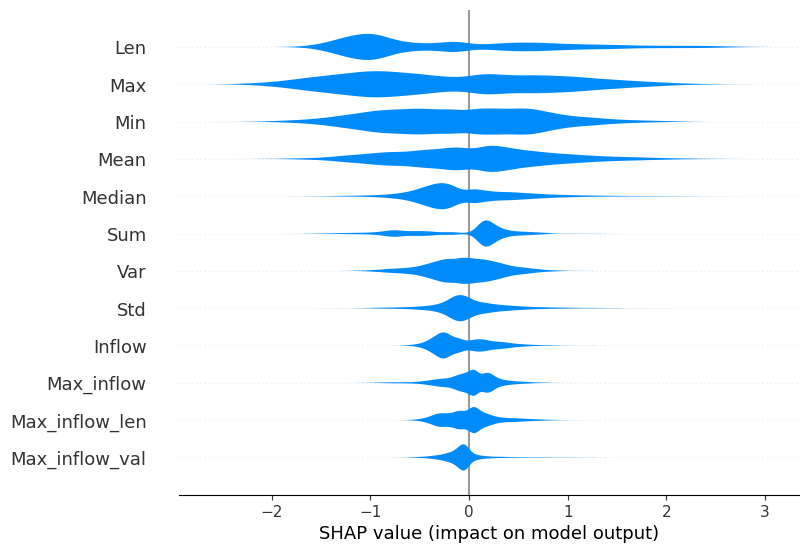

In [47]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.plots.violin(shap_values, feature_names=train.drop(['label', 'values', 'dates', 'id'], axis=1).columns, max_display=20)

In [38]:
import pickle
file_name = "model/xgb.pkl"
pickle.dump(xgb, open(file_name, "wb"))